基本思想：train a model to perform aggregation to the predictions of all predictors in an ensemble
首先由第一层的若干训练好的predictors对样本进行测试，测试结果作为另一个回归的数据集，输入第二层的predictor(称为blender或者meta learner)，以第一层预测结果为输入，得到最终的输出
策略：使用hold-out set,即将数据集划分成两个子集，第一层用第一个子集训练，然后用第二个子集作为第一层的test set。第二层中有几个predictor就有几个input features （n_dimension_second_layer = n_predictors_first_layer）

Stacking的特点：
①Models that have their predictions combined must have skill on the problem, but do not need to be the best possible models. This means that you do not need to tune the submodels intently, as long as the model shows some advantage over a baseline prediction.
即，不需要对子模型进行精细的调参
②It is important that sub-models produce different predictions, so-called uncorrelated predictions


一、Simple Stacked Classifier

Dataset:

In [26]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:,1:3]
y = iris.target

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier  #注意：接触到一个新的好用的库：mlxtend

In [36]:
clf1 = GaussianNB()
clf2 = KNeighborsClassifier(n_neighbors=1)
clf3 = RandomForestClassifier(random_state=1)
clf_blender = LogisticRegression()
clf_stacked = StackingClassifier(classifiers=[clf1,clf2,clf3],
                                 meta_classifier=clf_blender,
                                 #use_probas=True,  可选
                                 #average_probas=False,  可选
                                )


In [29]:
print('3-fold cross validation....')
tags = ['Naive Bayes','KNN','Random Forest','Stacking Classifier']
for clf,description in zip([clf1,clf2,clf3,clf_stacked],
                           tags):
    scores = cross_val_score(clf,X,y,cv=3,scoring='accuracy')
    print('Accuracy: {0:0.2f} (+/- {1:0.2f}) [{2}] '.format(scores.mean(), scores.std(), description))

3-fold cross validation....
Accuracy: 0.92 (+/- 0.03) [Naive Bayes] 
Accuracy: 0.91 (+/- 0.01) [KNN] 
Accuracy: 0.91 (+/- 0.06) [Random Forest] 
Accuracy: 0.95 (+/- 0.03) [Stacking Classifier] 


对结果进行可视化：

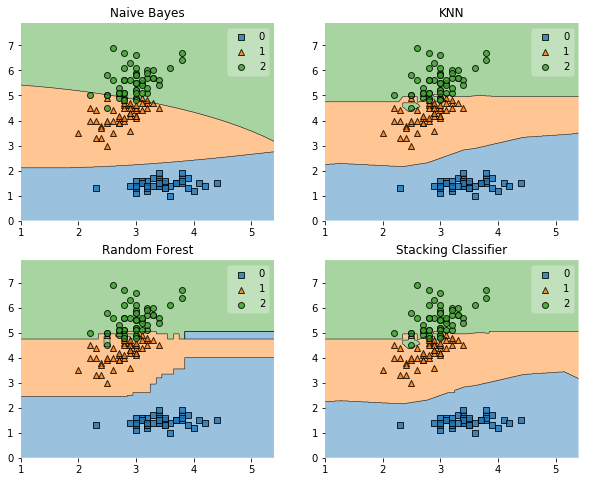

In [35]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools #itertools 参考http://www.wklken.me/posts/2013/08/20/python-extra-itertools.html
fig = plt.figure(figsize=(10,8))
gs =gridspec.GridSpec(2,2) #将整个图像窗口分成2行2列
#使用plt.subplot来作图, gs[0, :]表示这个图占第0行和所有列, gs[1, :2]表示这个图占第1行和第2列前的所有列, 
# gs[1:, 2]表示这个图占第1行后的所有行和第2列
for clf,describe,grd in zip([clf1,clf2,clf3,clf_stacked],tags,itertools.product([0,1],repeat=2)):
    clf.fit(X,y) #注意：这里虽然上面已经fit过了，在plot_decision_regions函数使用前还要fit一下？？
    ax=plt.subplot(gs[grd[0],grd[1]])
    plot_decision_regions(X=X,y=y,clf=clf)
    plt.title(describe)
                      

In [19]:
#itertools.product(p,q,repeat=num) ==> cartesian product, equivalent to a nested for-loop
for i in itertools.product('ABC',repeat=3):
    print(i)

('A', 'A', 'A')
('A', 'A', 'B')
('A', 'A', 'C')
('A', 'B', 'A')
('A', 'B', 'B')
('A', 'B', 'C')
('A', 'C', 'A')
('A', 'C', 'B')
('A', 'C', 'C')
('B', 'A', 'A')
('B', 'A', 'B')
('B', 'A', 'C')
('B', 'B', 'A')
('B', 'B', 'B')
('B', 'B', 'C')
('B', 'C', 'A')
('B', 'C', 'B')
('B', 'C', 'C')
('C', 'A', 'A')
('C', 'A', 'B')
('C', 'A', 'C')
('C', 'B', 'A')
('C', 'B', 'B')
('C', 'B', 'C')
('C', 'C', 'A')
('C', 'C', 'B')
('C', 'C', 'C')


二、Grid Search in stacking

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier__n_neighbors': [ 6],
          'randomforestclassifier__n_estimators': [41],
          'meta-logisticregression__C': [ 10.0],
         'randomforestclassifier__max_depth':[2,3,4]}  ##要按固定名字写。通过sclf.named_..查看clf名称及参数信息

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.3f' % grid.best_score_)

0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 6, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 41}
0.960 +/- 0.02 {'kneighborsclassifier__n_neighbors': 6, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 41}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 6, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 41}
Best parameters: {'kneighborsclassifier__n_neighbors': 6, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 41}
Accuracy: 0.960


In [67]:
grid.cv_results_['mean_test_score']
grid.cv_results_['params']

[{'kneighborsclassifier__n_neighbors': 6,
  'meta-logisticregression__C': 10.0,
  'randomforestclassifier__max_depth': 2,
  'randomforestclassifier__n_estimators': 41},
 {'kneighborsclassifier__n_neighbors': 6,
  'meta-logisticregression__C': 10.0,
  'randomforestclassifier__max_depth': 3,
  'randomforestclassifier__n_estimators': 41},
 {'kneighborsclassifier__n_neighbors': 6,
  'meta-logisticregression__C': 10.0,
  'randomforestclassifier__max_depth': 4,
  'randomforestclassifier__n_estimators': 41}]